# Imports

In [1]:
# !pip install timm
# %pip install opencv-python


In [2]:
import pickle
from tqdm import tqdm
import os
import numpy as np
import torch
import timm
from torch.utils.data import Dataset,DataLoader
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation
import pandas as pd
from sklearn.model_selection import train_test_split
# from dataset import GlaucomaDataset
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# %pip install numpy==1.23.0

# Dataset Class

In [5]:

import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation
import pandas as pd
import numpy as np
import cv2
from torchvision.transforms.functional import to_tensor


class GlaucomaDataset(Dataset):
    def __init__(self, root_dir, csv_file, image_dir='Images', mask_dir='Masks', split='train', output_size=(512,512), max_images=None):
        self.root_dir = root_dir
        self.csv_file = csv_file
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.split = split
        self.output_size = output_size
        self.max_images = max_images
        self.labels_df = pd.read_csv(os.path.join(root_dir, csv_file))

        # Define transformations for images and masks
        self.image_transform = Compose([
            Resize(output_size),
            ToTensor(),
            # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.mask_transform = Compose([
            Resize(output_size),
            ToTensor()
        ])

        # Load image file names
        self.image_filenames = self.get_image_filenames(root_dir, image_dir, max_images)

        print(f'Successfully loaded {split} dataset with {len(self.image_filenames)} images.')

    def get_image_filenames(self, root_dir, image_dir, max_images):
        image_filenames = [f for f in os.listdir(os.path.join(root_dir, image_dir)) if not f.startswith('.')]
        return image_filenames[:max_images] if max_images is not None else image_filenames

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image using cv2
        img_name = os.path.join(self.root_dir, self.image_dir, self.image_filenames[idx])
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, self.output_size)  # Resize the image

        # Initialize an empty mask with the same spatial dimensions as the image
        mask = np.zeros((*self.output_size, 1), dtype=np.uint8)

        # Load mask if it exists
        mask_name = os.path.join(self.root_dir, self.mask_dir, self.image_filenames[idx].replace('.jpg', '.png'))
        if os.path.exists(mask_name):
            mask_loaded = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
            mask_loaded = cv2.resize(mask_loaded, self.output_size)  # Resize the mask
            mask = mask_loaded[:, :, None]  # Add channel dimension

        # Concatenate image and mask
        img_with_mask = np.concatenate([img, mask], axis=-1)

        # Pad with zeros if necessary to ensure the concatenated result has exactly 5 channels
        if img_with_mask.shape[-1] < 5:
            padding = 5 - img_with_mask.shape[-1]
            img_with_mask = np.pad(img_with_mask, ((0, 0), (0, 0), (0, padding)), 'constant')

        # Convert the combined image and mask to a tensor without normalization
        img_with_mask_tensor = ToTensor()(img_with_mask)

        # Ensure the tensor has 5 channels where the last two channels are the mask
        if img_with_mask_tensor.shape[0] < 5:
            padding = 5 - img_with_mask_tensor.shape[0]
            padding_tensor = torch.zeros((padding, *self.output_size), dtype=torch.float32)
            img_with_mask_tensor = torch.cat([img_with_mask_tensor, padding_tensor], dim=0)

        # Get label
        label = self.labels_df.loc[self.labels_df['imageID'] == self.image_filenames[idx], 'binaryLabels'].values[0]
        label_tensor = torch.tensor(label, dtype=torch.long)

        return img_with_mask_tensor, label_tensor





# Loading Dataset

In [6]:
# !ls drive/MyDrive/G1020

In [7]:


# root_dir='../archive/G1020'
root_dir='../archive/G1020'


batch_size=8

# Initialize the dataset
dataset = GlaucomaDataset(root_dir=root_dir, csv_file='G1020.csv',)

# Initialize the data loader
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Successfully loaded train dataset with 1020 images.


In [8]:
len(dataset)

1020

# Check if correct masks and labels are loaded

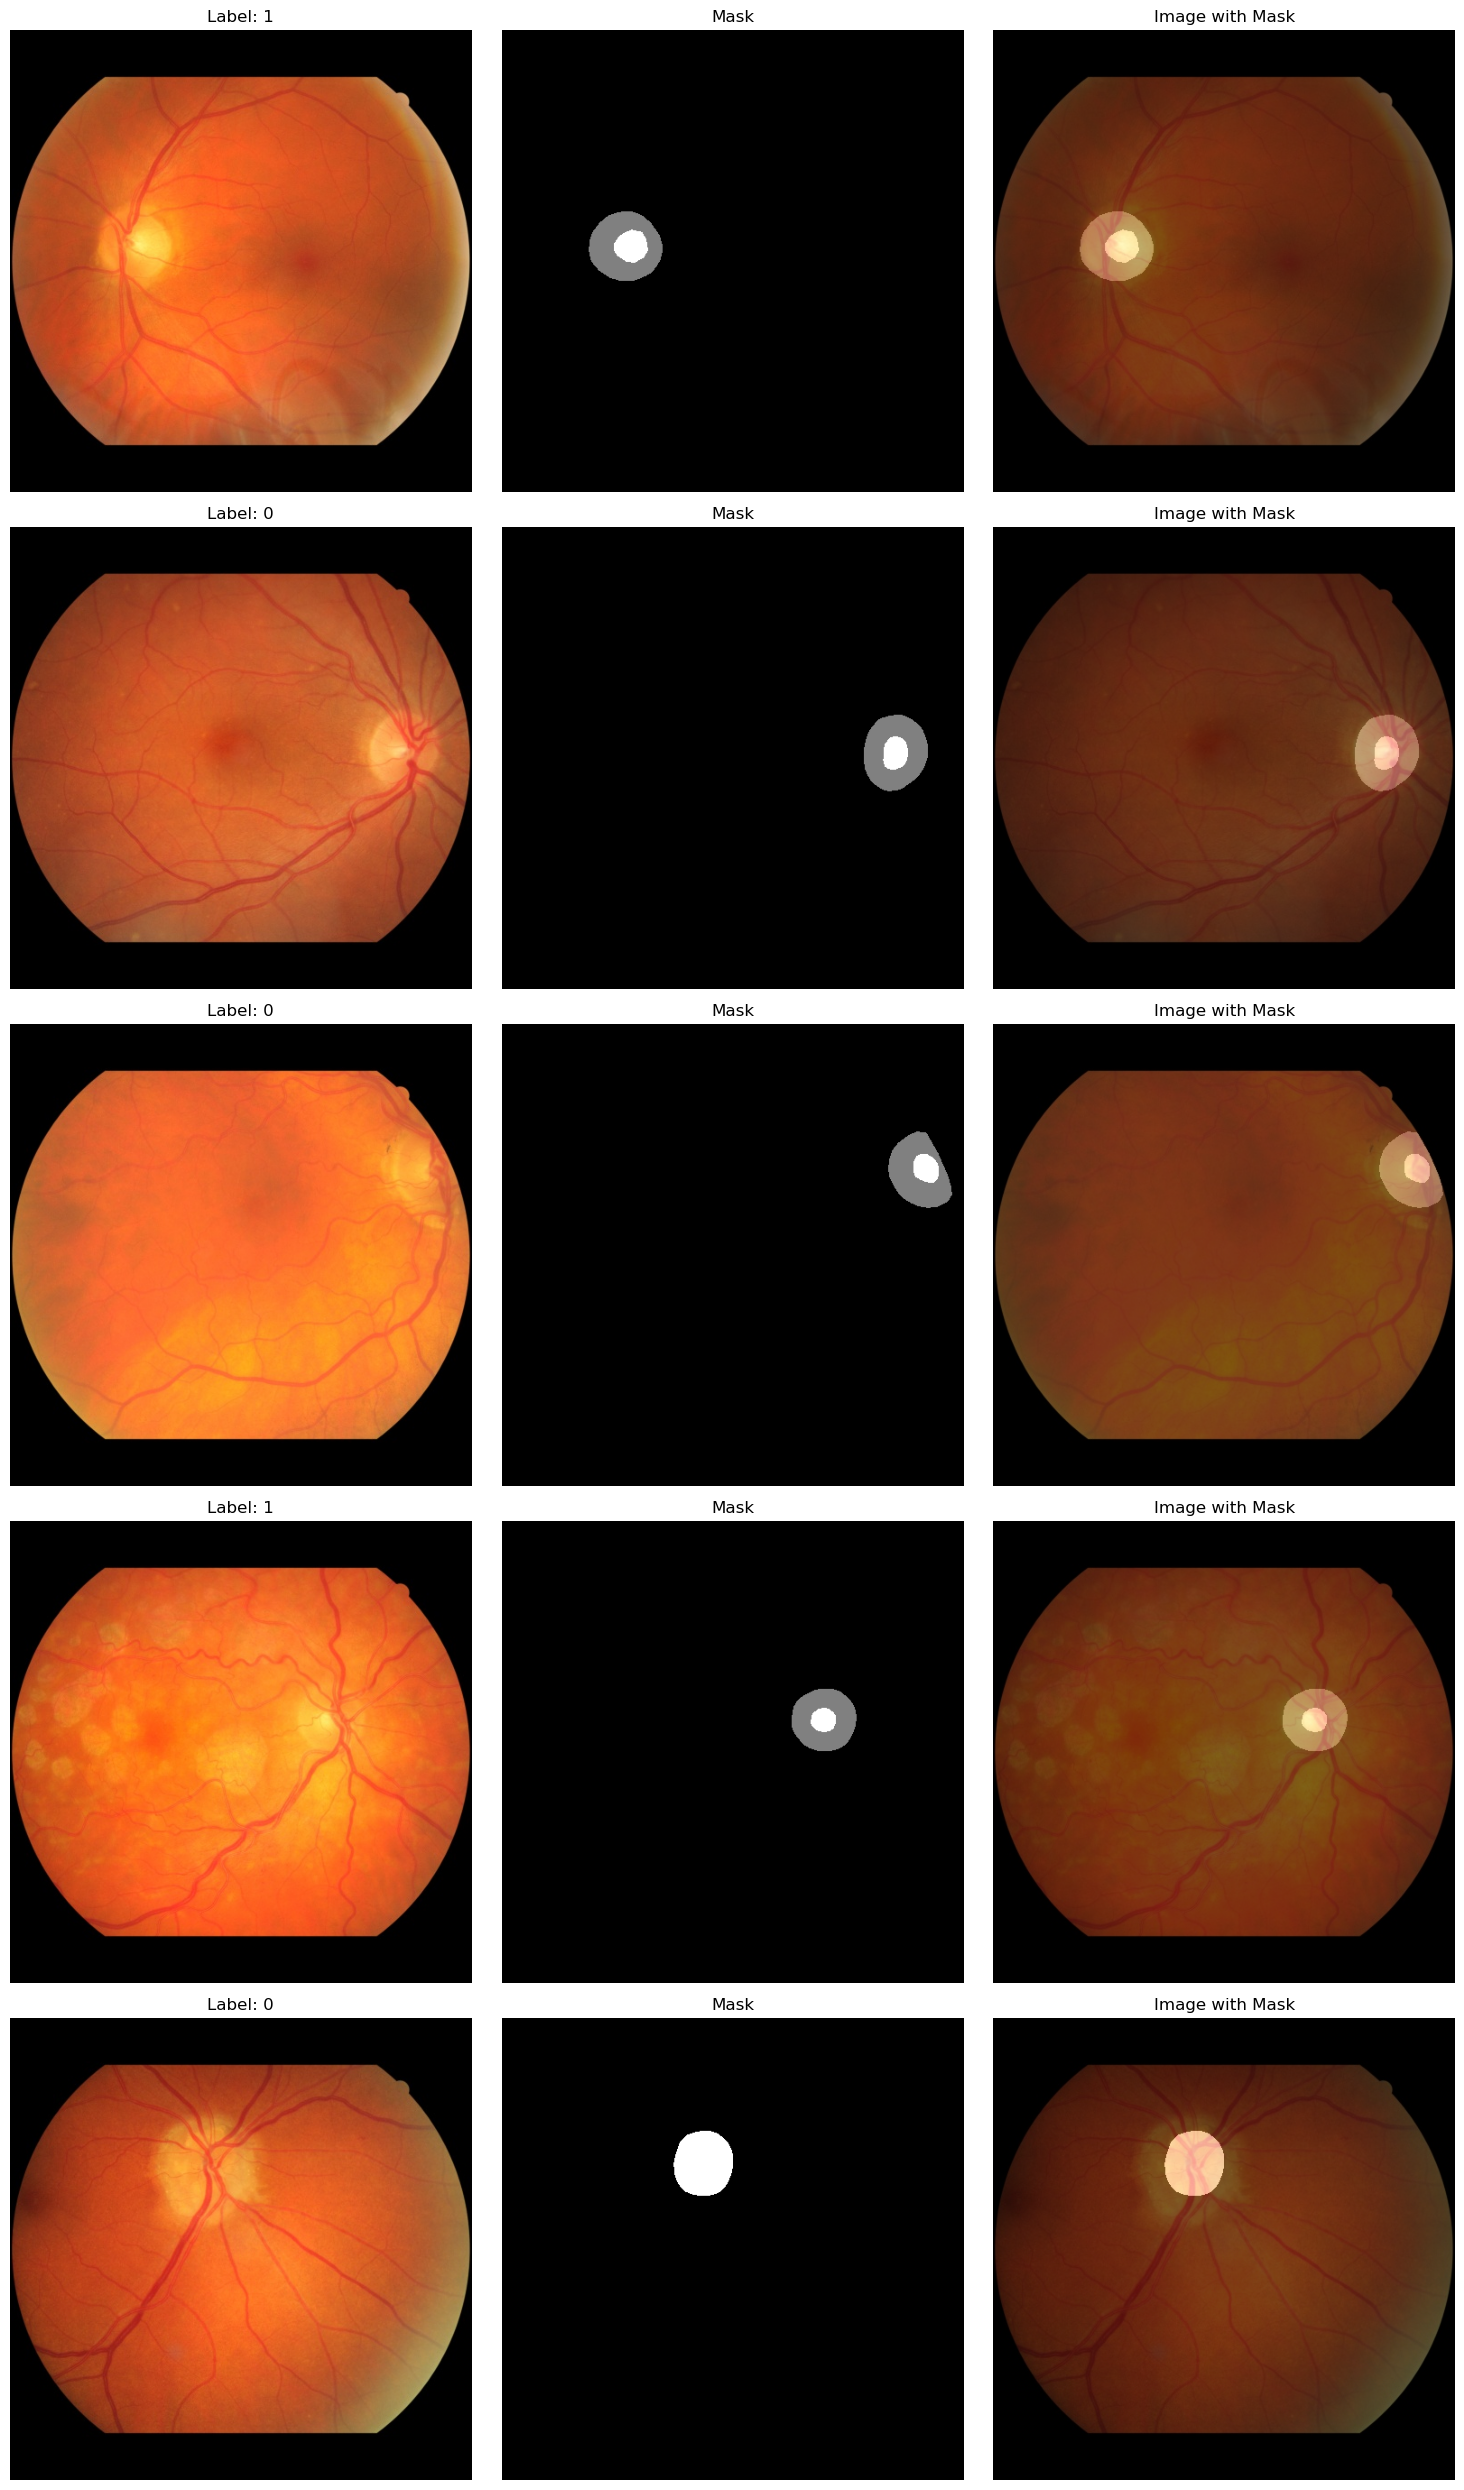

In [9]:
import matplotlib.pyplot as plt
import numpy as np

data_loader = DataLoader(dataset, num_workers=12,batch_size=batch_size, shuffle=True)

# Number of images to display
n_images = 5

# Randomly select n_images from the dataset
indices = np.random.choice(len(dataset), n_images, replace=False)
selected_images = [dataset[i] for i in indices]

# Plot the images with their masks and labels
fig, axes = plt.subplots(n_images, 3, figsize=(15, 5*n_images))
if n_images == 1:
    axes = np.expand_dims(axes, 0)
for i, (img_with_mask, label) in enumerate(selected_images):
    # Extract the image and mask from the combined tensor
    img = img_with_mask[:3, :, :]
    mask = img_with_mask[3, :, :]

    # Convert the image and mask to NumPy arrays for plotting
    img_np = img.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()

    # Normalize image values to [0, 1] if they're not already
    if img_np.max() > 1:
        img_np = img_np / 255.0

    # Display image
    ax = axes[i, 0]
    ax.imshow(img_np)
    ax.axis('off')
    ax.set_title(f'Label: {label.item()}')

    # Display mask
    ax = axes[i, 1]
    ax.imshow(mask_np, cmap='gray')
    ax.axis('off')
    ax.set_title('Mask')

    # Display image with mask overlaid
    ax = axes[i, 2]
    ax.imshow(img_np)
    ax.imshow(mask_np, cmap='gray', alpha=0.5)
    ax.axis('off')
    ax.set_title('Image with Mask')

plt.tight_layout()
plt.show()


# split dataset

In [10]:
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

In [11]:
train_loader = DataLoader(train_dataset,num_workers=12,batch_size=batch_size, shuffle=True)

In [12]:
val_loader = DataLoader(val_dataset, num_workers=12,batch_size=batch_size, shuffle=False)

# Initialize model

In [13]:
class CustomEfficientNet(nn.Module):
    def __init__(self, model_name='efficientnet_b6', num_classes=2, pretrained=True):
        super(CustomEfficientNet, self).__init__()

        # Define 3 convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(5, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.relu = nn.ReLU(inplace=True)

        # Initialize EfficientNet model
        self.model = timm.create_model(model_name,num_classes=num_classes,pretrained=pretrained, )

        # Modify the first convolutional layer of EfficientNet to accept 64 input channels
        self.model.conv_stem = nn.Conv2d(64, self.model.conv_stem.out_channels,
                                         kernel_size=self.model.conv_stem.kernel_size,
                                         stride=self.model.conv_stem.stride,
                                         padding=self.model.conv_stem.padding,
                                         bias=False)

        # Modify the batch normalization layer of EfficientNet
        self.model.bn1 = nn.BatchNorm2d(self.model.conv_stem.out_channels)

    def forward(self, x):
        # Apply 3 convolutional layers for feature extraction
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool3(x)

        # Forward pass through EfficientNet model
        x = self.model(x)
        return x


In [14]:

class CustomInceptionResNet(nn.Module):
    def __init__(self, model_name='inception_resnet_v2', num_classes=2, pretrained=True):
        super(CustomInceptionResNet, self).__init__()

        # Define 3 convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(5, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)

        # Initialize InceptionResNet model
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)

        # Modify the first convolutional layer to accept 64 channels instead of 3
        self.model.conv2d_1a.conv = nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

    def forward(self, x):
        # Apply 3 convolutional layers for feature extraction
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)

        # Forward pass through InceptionResNet model
        x = self.model(x)
        return x


In [15]:
# # Initialize the model

# model = CustomEfficientNet().to(device)

In [16]:

# Initialize the model
# model =CustomInceptionResNet().to(device)

# Hyper params and other stuff

# Training

In [17]:

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []
model = CustomEfficientNet( model_name='efficientnet_b6', num_classes=2, pretrained=False).to(device)
# Load the best model
model.load_state_dict(torch.load("best_model.pth"))
print("Best model loaded")

# Load the lists
with open('training_metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)
    train_loss_list = metrics['train_loss_list']
    val_loss_list = metrics['val_loss_list']
    train_accuracy_list = metrics['train_accuracy_list']
    val_accuracy_list = metrics['val_accuracy_list']

print("Metrics loaded")

Best model loaded
Metrics loaded


In [18]:

model = CustomEfficientNet( model_name='efficientnet_b7', num_classes=2, pretrained=False).to(device)
# Initialize optimizer and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Loss function
criterion = torch.nn.CrossEntropyLoss()


# Training loop
num_epochs = 35



best_val_loss = float('inf')
patience = 8
early_stopping_counter = 0

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []


for epoch in tqdm(range(num_epochs), desc='Epochs '):
    model.train()
    total_train_loss = 0
    total_correct_train = 0
    total_train_samples = 0
    for batch in train_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        _, predicted_train = torch.max(outputs, 1)
        total_correct_train += (predicted_train == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = (total_train_loss / len(train_loader))
    train_loss_list.append(avg_train_loss)

    train_accuracy = (total_correct_train / total_train_samples) *100
    train_accuracy_list.append(train_accuracy)

    # Validation loop
    model.eval()
    total_val_loss = 0
    total_correct_val = 0
    total_val_samples = 0
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()

            _, predicted_val = torch.max(outputs, 1)
            total_correct_val += (predicted_val == labels).sum().item()
            total_val_samples += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_list.append(avg_val_loss)

    val_accuracy = (total_correct_val / total_val_samples) *100
    val_accuracy_list.append(val_accuracy)

    # Update learning rate
    scheduler.step(avg_val_loss)

    # Print loss and accuracy for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy :.2f}%, Val Loss: {avg_val_loss}, Val Accuracy: {val_accuracy :.2f}%")

    # Save model and lists if validation loss has improved
    if epoch > 5 and avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Model saved")
        # Also save the lists
        with open('training_metrics.pkl', 'wb') as f:
            pickle.dump({
                'train_loss_list': train_loss_list,
                'val_loss_list': val_loss_list,
                'train_accuracy_list': train_accuracy_list,
                'val_accuracy_list': val_accuracy_list
            }, f)
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping")
            break

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))
print("Best model loaded")

# Load the lists
with open('training_metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)
    train_loss_list = metrics['train_loss_list']
    val_loss_list = metrics['val_loss_list']
    train_accuracy_list = metrics['train_accuracy_list']
    val_accuracy_list = metrics['val_accuracy_list']

print("Metrics loaded")


Epochs :   3%|▎         | 1/35 [00:10<06:11, 10.92s/it]

Epoch 1/35, Train Loss: 5.217726401893385, Train Accuracy: 59.68%, Val Loss: 9.346305764065338, Val Accuracy: 72.06%


Epochs :   6%|▌         | 2/35 [00:19<05:16,  9.60s/it]

Epoch 2/35, Train Loss: 1.1360672493191326, Train Accuracy: 62.38%, Val Loss: 7.57392180367158, Val Accuracy: 68.14%


Epochs :   9%|▊         | 3/35 [00:28<04:51,  9.10s/it]

Epoch 3/35, Train Loss: 1.1081057284392564, Train Accuracy: 61.15%, Val Loss: 38.978302258711594, Val Accuracy: 32.35%


Epochs :  11%|█▏        | 4/35 [00:36<04:34,  8.85s/it]

Epoch 4/35, Train Loss: 0.9340974004829631, Train Accuracy: 63.60%, Val Loss: 1.935950409907561, Val Accuracy: 71.57%


Epochs :  14%|█▍        | 5/35 [00:45<04:21,  8.71s/it]

Epoch 5/35, Train Loss: 0.8721895973179855, Train Accuracy: 64.83%, Val Loss: 3.175930129793974, Val Accuracy: 70.10%


Epochs :  17%|█▋        | 6/35 [00:54<04:19,  8.93s/it]

Epoch 6/35, Train Loss: 0.9421757958902448, Train Accuracy: 62.13%, Val Loss: 4.193979130914578, Val Accuracy: 60.78%
Epoch 7/35, Train Loss: 0.8954466515604187, Train Accuracy: 63.11%, Val Loss: 2.733264047365922, Val Accuracy: 58.82%


Epochs :  20%|██        | 7/35 [01:04<04:17,  9.19s/it]

Model saved


Epochs :  23%|██▎       | 8/35 [01:13<04:09,  9.25s/it]

Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/35, Train Loss: 0.9180459483873611, Train Accuracy: 62.50%, Val Loss: 10.491602528553743, Val Accuracy: 34.31%
Epoch 9/35, Train Loss: 0.6873763731005145, Train Accuracy: 69.61%, Val Loss: 1.9108525812625885, Val Accuracy: 72.55%


Epochs :  26%|██▌       | 9/35 [01:23<04:02,  9.34s/it]

Model saved
Epoch 10/35, Train Loss: 0.64517415943099, Train Accuracy: 68.75%, Val Loss: 1.2389681809223616, Val Accuracy: 70.10%


Epochs :  29%|██▊       | 10/35 [01:32<03:52,  9.31s/it]

Model saved


Epochs :  31%|███▏      | 11/35 [01:41<03:42,  9.25s/it]

Epoch 11/35, Train Loss: 0.6202569618528965, Train Accuracy: 69.24%, Val Loss: 1.778728580245605, Val Accuracy: 72.06%


Epochs :  34%|███▍      | 12/35 [01:50<03:32,  9.22s/it]

Epoch 12/35, Train Loss: 0.6425373174396216, Train Accuracy: 69.36%, Val Loss: 2.074921441765932, Val Accuracy: 61.76%
Epoch 13/35, Train Loss: 0.6329619871342883, Train Accuracy: 69.85%, Val Loss: 0.7145786514649024, Val Accuracy: 72.06%


Epochs :  37%|███▋      | 13/35 [01:59<03:23,  9.24s/it]

Model saved


Epochs :  40%|████      | 14/35 [02:08<03:12,  9.17s/it]

Epoch 14/35, Train Loss: 0.6318040479924164, Train Accuracy: 70.83%, Val Loss: 1.0437150116150196, Val Accuracy: 70.10%


Epochs :  43%|████▎     | 15/35 [02:17<03:03,  9.16s/it]

Epoch 15/35, Train Loss: 0.63000773521615, Train Accuracy: 70.47%, Val Loss: 1.3249387385753484, Val Accuracy: 71.57%


Epochs :  46%|████▌     | 16/35 [02:27<02:53,  9.15s/it]

Epoch 16/35, Train Loss: 0.636665338102509, Train Accuracy: 69.12%, Val Loss: 1.0091626942157745, Val Accuracy: 68.14%


Epochs :  49%|████▊     | 17/35 [02:36<02:44,  9.14s/it]

Epoch 00017: reducing learning rate of group 0 to 1.0000e-05.
Epoch 17/35, Train Loss: 0.6407173465864331, Train Accuracy: 68.63%, Val Loss: 1.6431048248822873, Val Accuracy: 68.63%


Epochs :  51%|█████▏    | 18/35 [02:45<02:35,  9.13s/it]

Epoch 18/35, Train Loss: 0.6110313683748245, Train Accuracy: 70.71%, Val Loss: 0.7955246510413977, Val Accuracy: 71.08%


Epochs :  54%|█████▍    | 19/35 [02:54<02:25,  9.09s/it]

Epoch 19/35, Train Loss: 0.6018811698053398, Train Accuracy: 70.71%, Val Loss: 1.0834352030203893, Val Accuracy: 70.10%


Epochs :  57%|█████▋    | 20/35 [03:03<02:16,  9.07s/it]

Epoch 20/35, Train Loss: 0.6072636971286699, Train Accuracy: 70.71%, Val Loss: 1.0673928157641337, Val Accuracy: 71.08%


Epochs :  57%|█████▋    | 20/35 [03:12<02:24,  9.61s/it]

Epoch 00021: reducing learning rate of group 0 to 1.0000e-06.
Epoch 21/35, Train Loss: 0.6089438185387966, Train Accuracy: 70.59%, Val Loss: 0.7625163266291985, Val Accuracy: 72.06%
Early stopping
Best model loaded
Metrics loaded


# Evaluation

In [19]:


# # Load the model and set it to evaluation mode
# model= CustomEfficientNet(pretrained=False)
# model.to(device)

# model.load_state_dict(torch.load("best_model.pth"))
# model.eval()


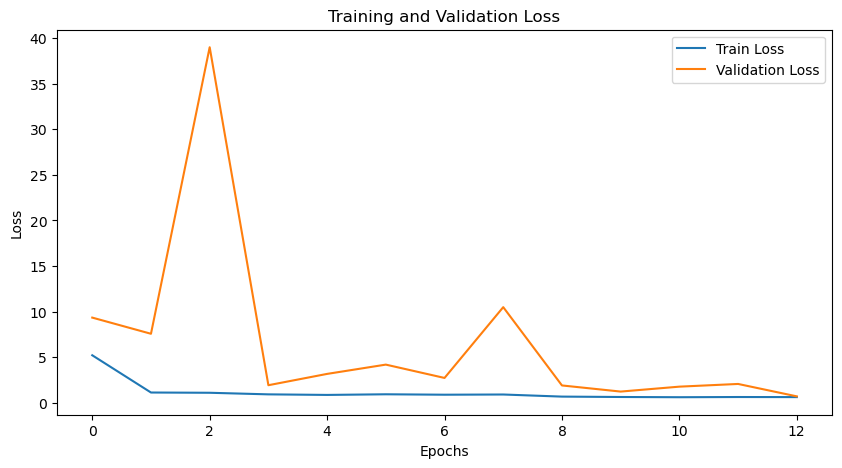

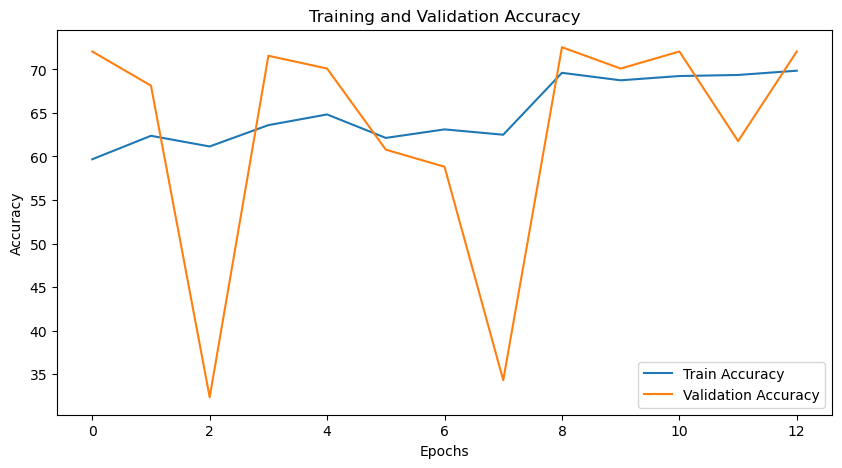

In [20]:

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.97      0.83       147
           1       0.50      0.09      0.15        57

    accuracy                           0.72       204
   macro avg       0.62      0.53      0.49       204
weighted avg       0.67      0.72      0.64       204



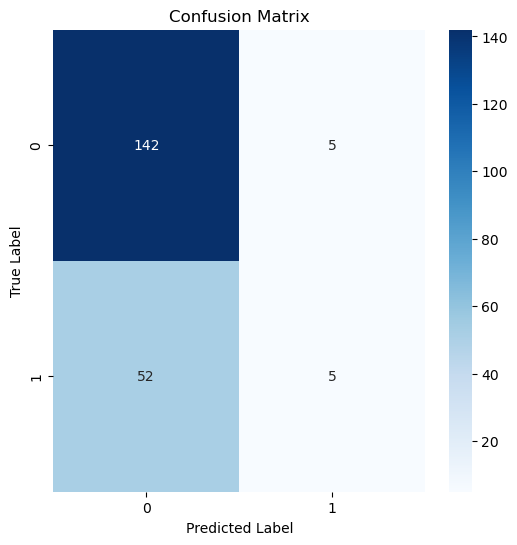

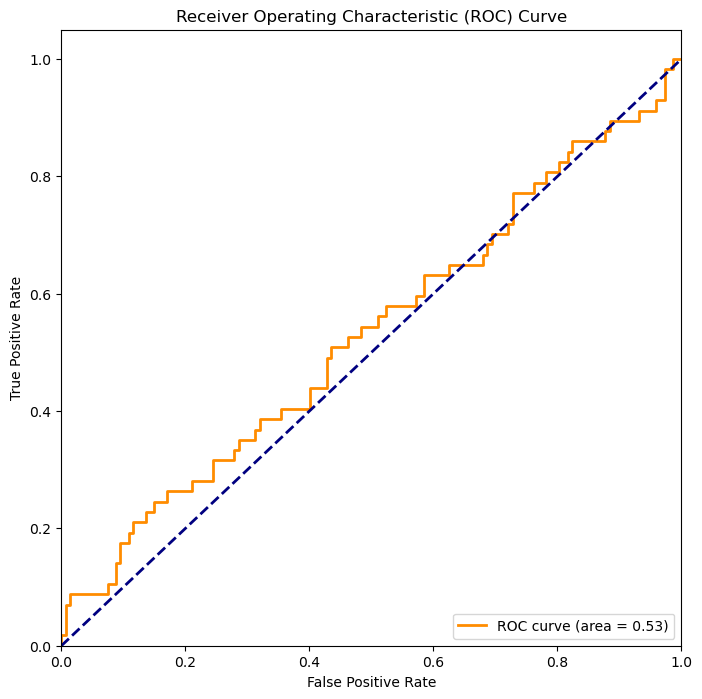

In [21]:


from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize lists to store true labels, predicted labels, and predicted probabilities
true_labels = []
predicted_labels = []
predicted_probs = []

# Validation loop
model.eval()
with torch.no_grad():
    for batch in val_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Store true labels and predicted labels
        true_labels.extend(labels.cpu().numpy())

        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())

        # Store predicted probabilities for the positive class
        probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
        predicted_probs.extend(probs.cpu().numpy())

# Generate classification report
report = classification_report(true_labels, predicted_labels)
print('Classification Report:\n', report)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Evaluation - visualised

In [22]:
# ! pip install grad-cam


In [23]:

import random

# Load 10 random images from the validation set
images = []
labels = []
for _ in range(10):
    idx = random.randint(0, len(val_loader.dataset) - 1)
    img, label = val_loader.dataset[idx]
    images.append(img)
    labels.append(label)


In [24]:
# images

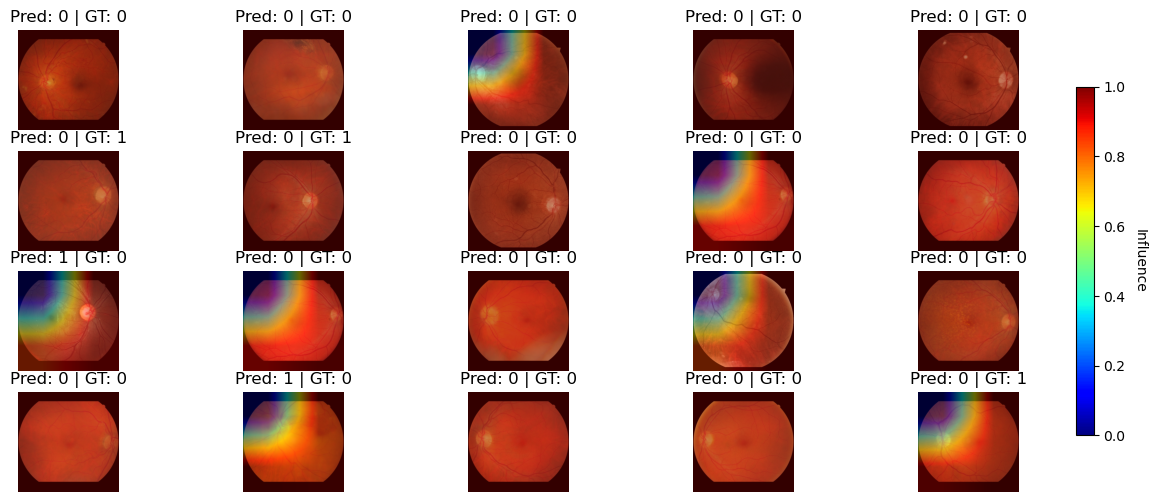

In [25]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import random

# Load 10 random images from the validation set
images = []
labels = []
num_images=20
for _ in range(20):
    idx = random.randint(0, len(val_loader.dataset) - 1)
    img, label = val_loader.dataset[idx]
    images.append(img)
    labels.append(label)

# Convert the list of images to a torch tensor
images = torch.stack(images)
labels = torch.tensor(labels)



# Hook to extract the feature maps and gradients
feature_maps = []
gradients = []
def forward_hook(module, input, output):
    feature_maps.append(output)
def backward_hook(module, input, output):
    gradients.append(output[0])

# Register the hooks
model.model.blocks[-1].register_forward_hook(forward_hook)
model.model.blocks[-1].register_full_backward_hook(backward_hook)


# Forward pass and compute Grad-CAM
images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Compute gradients
outputs[:, predicted].backward(torch.ones_like(outputs[:, predicted]))

# Compute weights
weights = torch.mean(gradients[0], dim=(2, 3))

# Compute Grad-CAM heatmap
heatmaps = []
for i in range(images.size(0)):
    heatmap = torch.sum(weights[i].view(-1, 1, 1) * feature_maps[0][i], dim=0)
    heatmap = F.relu(heatmap)
    heatmap = heatmap / torch.max(heatmap)
    heatmaps.append(heatmap.cpu().detach().numpy())

# Convert images to NumPy array
images_np = images.cpu().numpy()

# Overlay heatmap on original images and display them
fig, axes = plt.subplots(4, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(num_images):
    ax = axes[i]
    img = images_np[i][:3, :, :].transpose((1, 2, 0))  # Extract first 3 channels and convert from CHW to HWC format
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
    img = np.uint8(255 * img)  # Convert to uint8
    heatmap = heatmaps[i]
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    ax.imshow(superimposed_img)
    ax.set_title(f'Pred: {predicted[i].item()} | GT: {labels[i].item()}')
    ax.axis('off')



# Add color bar
sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(0, 1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.015, pad=0.05)
cbar.set_label('Influence', rotation=270, labelpad=15)

# plt.tight_layout()
plt.show()

# Class wise density maps

In [26]:
# %pip install tqdm

In [27]:
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt
# import cv2
# import numpy as np


# print(device)

# # Load the model and set it to evaluation mode
# # model= CustomEfficientNet(pretrained=False)
# model.to(device)

# # model.load_state_dict(torch.load("drive/MyDrive/best_model.pth"))
# # model.eval()

# # Ensure the model is in evaluation mode
# model.eval()

# # Initialize variables to store feature maps and gradients
# num_classes = 2  # Assuming binary classification
# num_feature_maps = None  # This will be set after the forward hook
# batch_feature_maps = []
# batch_gradients = []

# # Forward and backward hooks
# def forward_hook(module, input, output):
#     global num_feature_maps
#     batch_feature_maps.append(output)
#     if num_feature_maps is None:
#         num_feature_maps = output.size(1)

# def backward_hook(module, input, output):
#     batch_gradients.append(output[0])

# # Register the hooks
# # Register the hooks
# model.model.blocks[-1].register_forward_hook(forward_hook)
# model.model.blocks[-1].register_full_backward_hook(backward_hook)

# # Process the first batch from the validation dataset
# imgs, labels = next(iter(val_loader))
# imgs = imgs.to(device)

# # Forward pass to get the raw model outputs
# outputs = model(imgs)

# # Backward pass for each class
# one_hot_output = torch.zeros_like(outputs)
# for class_idx in tqdm(range(num_classes), desc='Computing backward pass for each class'):
#     model.zero_grad()
#     one_hot_output.zero_()
#     one_hot_output[:, class_idx] = 1
#     class_output = (outputs * one_hot_output).sum(dim=1)
#     class_output.backward(gradient=torch.ones_like(class_output), retain_graph=True)

# print("1")
# # Detach and move to CPU
# fmaps = batch_feature_maps[0].detach().cpu()
# print("2")

# grads = batch_gradients[0].detach().cpu()
# print("3")


# # Convert images to grayscale once
# imgs_np = imgs.cpu().numpy()
# print("4")

# imgs_gray_np = np.stack([
#     cv2.cvtColor(img[:3].transpose((1, 2, 0)), cv2.COLOR_RGB2GRAY) 
#     for img in imgs_np
# ])
# print("5")

# # Visualization
# num_images = imgs.size(0)
# print("6")

# fig, axes = plt.subplots(num_images, num_feature_maps * num_classes, figsize=(20, 10))

# print("7")

# for img_idx in tqdm(range(num_images), desc='Generating heatmaps'):
#     img_gray = imgs_gray_np[img_idx]
#     img_gray_bgr = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
#     superimposed_imgs = []
    
#     for class_idx in tqdm(range(num_images), desc='Getting Gradients'):
#         # Retrieve the gradients for the image, not for the class
#         grad = grads[img_idx]
#         fmap = fmaps[img_idx]
#         weights = torch.mean(grad, dim=[1, 2], keepdim=True)
#         class_heatmap = torch.sum(weights * fmap, dim=0)
#         class_heatmap = F.relu(class_heatmap).numpy()
        
#         # Normalize the heatmap
#         class_heatmap = class_heatmap - np.min(class_heatmap)
#         class_heatmap = class_heatmap / np.max(class_heatmap)
        
#         # Resize to match the image size
#         class_heatmap = cv2.resize(class_heatmap, (img_gray.shape[1], img_gray.shape[0]))
        
#         # Convert to a color heatmap
#         class_heatmap = np.uint8(255 * class_heatmap)
#         class_heatmap = cv2.applyColorMap(class_heatmap, cv2.COLORMAP_JET)
        
#         # Superimpose the heatmap on grayscale image
#         superimposed_img = cv2.addWeighted(img_gray_bgr, 0.6, class_heatmap, 0.4, 0)
#         superimposed_imgs.append(superimposed_img)
    
#     # Now you have two superimposed images in the list: superimposed_imgs
#     # You can display them side by side for comparison or overlay them
#     # Here we will overlay the class 1 heatmap onto the class 0 heatmap
#     combined_superimposed_img = cv2.addWeighted(superimposed_imgs[0], 0.5, superimposed_imgs[1], 0.5, 0)
    
#     # Display the combined image
#     ax = axes[img_idx]
#     ax.imshow(combined_superimposed_img)
#     ax.set_title(f'Image {img_idx}')
#     ax.axis('off')

# plt.tight_layout()
# plt.show()


cpu


Processing validation set:   0%|          | 0/26 [00:00<?, ?it/s]

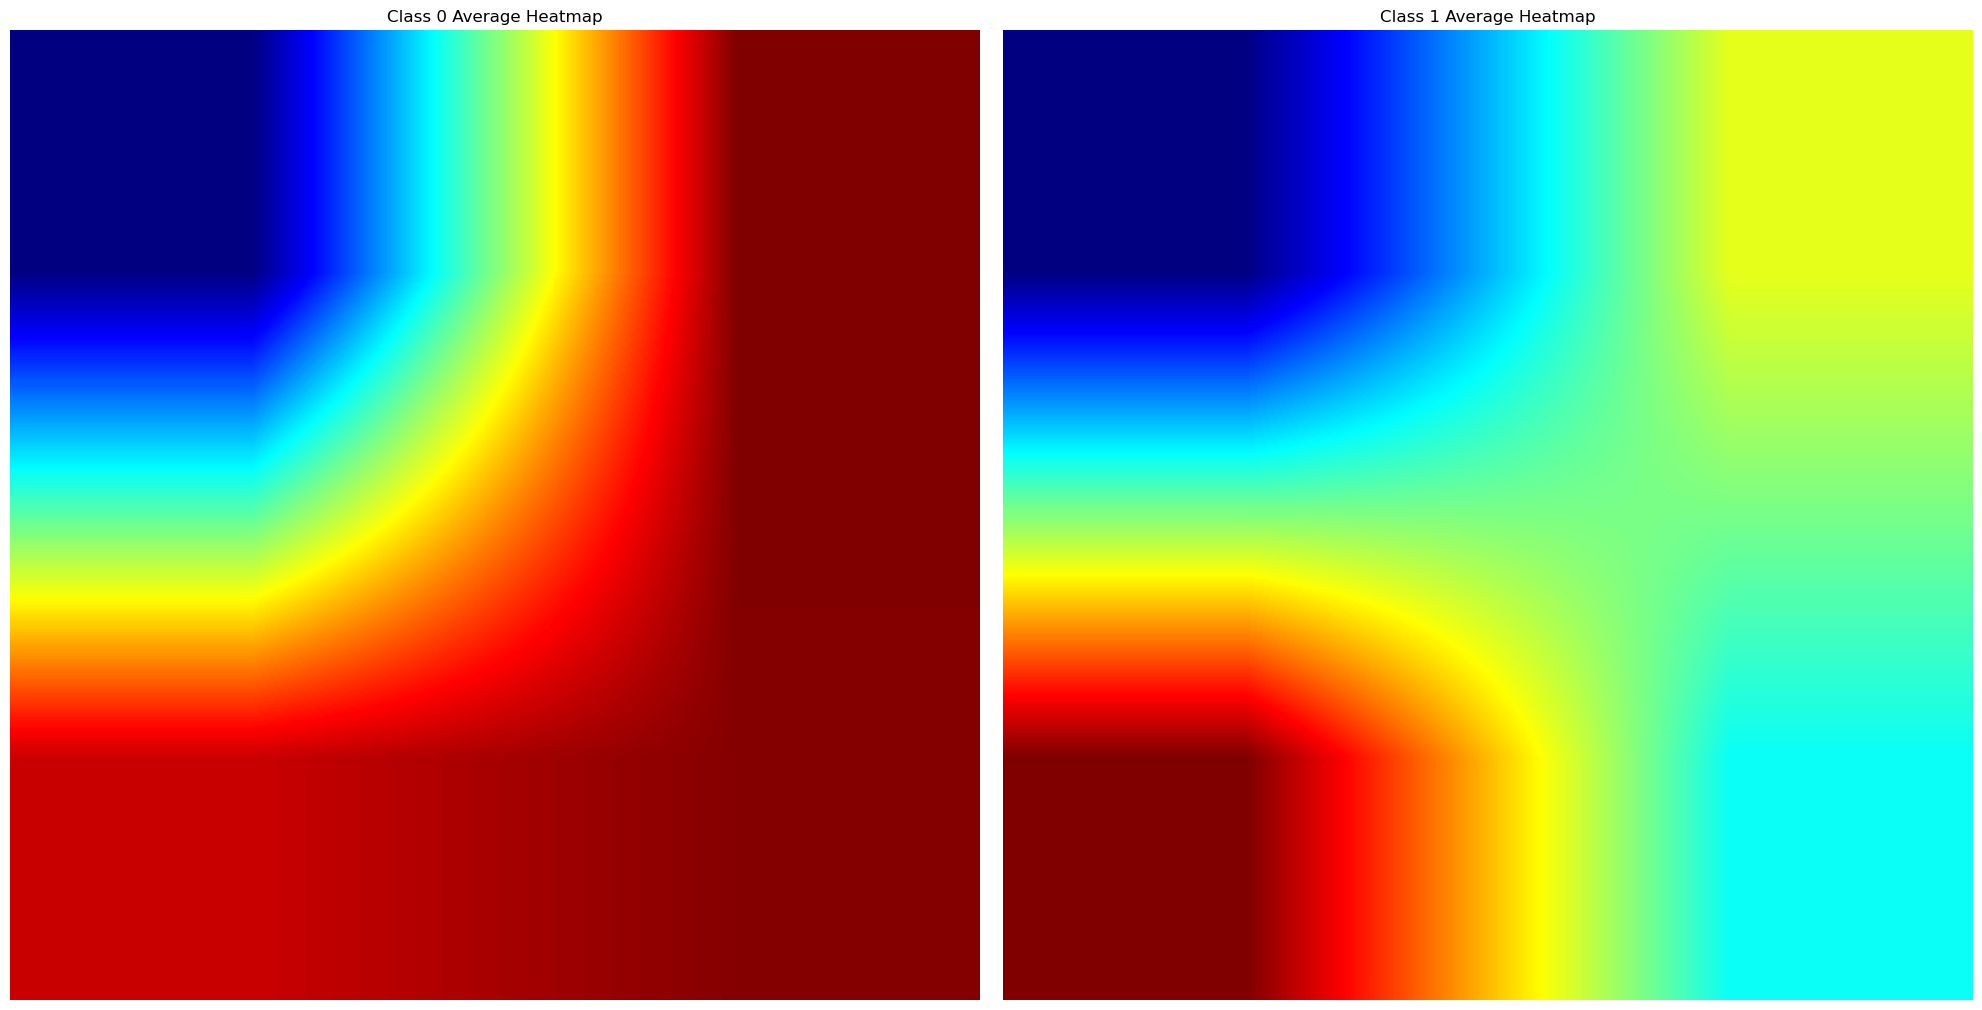

In [28]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm.auto import tqdm

# Assuming device is already set to 'cuda' if available
device='cpu'
print(device)
num_classes = 2  # Assuming binary classification
num_feature_maps = None  # This will be set after the forward hook
batch_feature_maps = []
batch_gradients = []

# Load the model to device and set it to evaluation mode
model.to(device)
model.eval()

height,width=512,512

# Initialize accumulators for heatmaps for each class
# Given image size is 512x512
class_accumulated_heatmaps = [torch.zeros((1, height,width), device=device) for _ in range(num_classes)]
total_images = 0  # Counter for total number of images processed

# Forward and backward hooks
def forward_hook(module, input, output):
    batch_feature_maps.append(output)

def backward_hook(module, input, output):
    batch_gradients.append(output[0])

# Register the hooks on the last convolutional layer
model.model.blocks[-1].register_forward_hook(forward_hook)
model.model.blocks[-1].register_full_backward_hook(backward_hook)

# Loop through the validation dataset
for imgs, _ in tqdm(val_loader, desc='Processing validation set'):
    imgs = imgs.to(device)
    outputs = model(imgs)
    one_hot_output = torch.zeros_like(outputs)

    # Backward pass for each class
    for class_idx in range(num_classes):
        model.zero_grad()
        one_hot_output.zero_()
        one_hot_output[:, class_idx] = 1
        class_output = (outputs * one_hot_output).sum()
        class_output.backward(retain_graph=True)

        # Retrieve and process feature maps and gradients
        grads = batch_gradients[-1].detach()
        fmaps = batch_feature_maps[-1].detach()
        weights = torch.mean(grads, dim=(2, 3), keepdim=True)
        class_heatmap = (weights * fmaps).sum(dim=1)
        class_heatmap = F.relu(class_heatmap)

        # Normalize the heatmap
        max_value = class_heatmap.max()
        if max_value > 0:
            class_heatmap /= max_value
        # Average the heatmaps across the batch and add a batch dimension
        averaged_class_heatmap = class_heatmap.mean(dim=0, keepdim=True).unsqueeze(0)

        # Ensure we have the correct number of dimensions
        if averaged_class_heatmap.ndim == 4:
            # Resize the averaged heatmap to match the target size (512x512)
            averaged_class_heatmap = F.interpolate(averaged_class_heatmap, size=(height,width), mode='bilinear', align_corners=False)
        else:
            # Handle unexpected number of dimensions
            raise ValueError("Unexpected number of dimensions in the averaged_class_heatmap.")

        # Remove the batch dimension after interpolation
        averaged_class_heatmap = averaged_class_heatmap.squeeze(0)

        # Accumulate the heatmaps
        class_accumulated_heatmaps[class_idx] += averaged_class_heatmap

    total_images += imgs.size(0)
    batch_feature_maps.clear()
    batch_gradients.clear()

# Average the heatmaps over all images
class_accumulated_heatmaps = [heatmap / total_images for heatmap in class_accumulated_heatmaps]

# Convert the accumulated heatmaps to numpy for visualization
class_accumulated_heatmaps_np = [heatmap.squeeze().cpu().numpy() for heatmap in class_accumulated_heatmaps]

# Visualization
fig, axes = plt.subplots(1, num_classes, figsize=(10 * num_classes, 10))
for class_idx, class_heatmap in enumerate(class_accumulated_heatmaps_np):
    # Normalize the heatmap to range [0, 1]
    class_heatmap_normalized = (class_heatmap - np.min(class_heatmap)) / (np.max(class_heatmap) - np.min(class_heatmap))
    
    # Resize heatmap to match the image size (512x512)
    class_heatmap_resized = cv2.resize(class_heatmap_normalized, (512, 512))
    
    # Convert to a color heatmap (expects values in the range [0, 255])
    class_heatmap_color = cv2.applyColorMap(np.uint8(255 * class_heatmap_resized), cv2.COLORMAP_JET)
    
    axes[class_idx].imshow(class_heatmap_color)
    axes[class_idx].set_title(f'Class {class_idx} Average Heatmap')
    axes[class_idx].axis('off')

plt.tight_layout()
plt.show()

In [29]:
torch.cuda.empty_cache()

In [30]:
# print(class_heatmap_resized)